In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib
import matplotlib.lines as mlines
import pickle as pk

In [38]:
dataset = 'cifar100'
model = 't2t_14'
if dataset == 'cifar10':
    min_ic = 0
    max_ic = 100
if dataset == 'cifar100':
    min_ic = 0
    max_ic = 100

In [39]:
with open(dataset+'_'+model+'/'+dataset+'_boosted_results.pk', 'rb') as file:
        list_dict_boosted = pk.load(file)
        
with open(dataset+'_'+model+'/'+dataset+'_weighted_results.pk', 'rb') as file:
        list_dict_weighted = pk.load(file)
        

In [40]:
path = dataset+'_'+model+'/'
list_files = os.listdir(path)

list_dicts_ours = []
for file_name in list_files:
    if '.pk' in file_name and 'boosted' not in file_name and 'weighted' not in file_name and 'bigger' in file_name:
        print(file_name)
        with open(os.path.join(path, file_name), 'rb') as file:
            dicts = pk.load(file)
        list_dicts_ours.append(dicts)


bigger_runs_cifar100_2.0_results.pk
bigger_runs_cifar100_5.0_results.pk


In [41]:
def extract_metrics_we_want(metrics_dict, keys_we_want):
    metrics_we_want = {}
    for key, val in metrics_dict.items():
        if key in keys_we_want:
            metrics_we_want[key] = val
    return metrics_we_want

def get_all_cov_C(metrics):
    cov_keys = []
    C_keys = []
    for key in metrics.keys():
        if 'cov' in key:
            tokens = key.split('cov')
            alpha = tokens[1]
            prefix = tokens[0]
            cov_key = prefix+'cov'+alpha
            C_key = prefix+'C'+alpha
            cov_keys.append(cov_key)
            C_keys.append(C_key)
    return cov_keys, C_keys
def get_all_key_with(metrics, substring):
    keys_with_substring = []
    for key in metrics.keys():
        if substring in key:
            keys_with_substring.append(key)
    return keys_with_substring

def find_highest_cov(metrics_we_care_about, cov_keys, requested_alpha):
    alpha_max = 0
    for cov_key in cov_keys:
        alpha_val = float(cov_key.split('_')[-1])
        emp_cov = metrics_we_care_about['average'+cov_key]
        #print(emp_cov)
        if 1-emp_cov< requested_alpha:
            if alpha_max < alpha_val:
                alpha_max = alpha_val
                #print('switching fot', alpha_val)
    #print('highest alpha is ', alpha_max, 'with emp cov', )
    return alpha_max
            
        


In [42]:
our_df = pd.DataFrame()
keys_we_want = ['test/acc_exit','test/total_cost', 'test/gated_acc', 'test/gated_ece', 'test/gated_ece']
cov_keys, C_keys = get_all_cov_C(list_dicts_ours[0])
keys_we_want = keys_we_want + cov_keys + C_keys
keys_gated_accs = get_all_key_with(list_dicts_ours[-1], 'gated_acc_')
keys_all_acc = get_all_key_with(list_dicts_ours[-1], 'test/acc')
keys_we_want = keys_we_want
print(keys_we_want)

['test/acc_exit', 'test/total_cost', 'test/gated_acc', 'test/gated_ece', 'test/gated_ece', 'test/cov_0.01', 'test/cov_0.015', 'test/cov_0.02', 'test/cov_0.025', 'test/cov_0.03', 'test/cov_0.035', 'test/cov_0.04', 'test/cov_0.045', 'test/cov_0.05', 'test/gen_cov_0.01', 'test/gen_cov_0.015', 'test/gen_cov_0.02', 'test/gen_cov_0.025', 'test/gen_cov_0.03', 'test/gen_cov_0.035', 'test/gen_cov_0.04', 'test/gen_cov_0.045', 'test/gen_cov_0.05', 'test/C_0.01', 'test/C_0.015', 'test/C_0.02', 'test/C_0.025', 'test/C_0.03', 'test/C_0.035', 'test/C_0.04', 'test/C_0.045', 'test/C_0.05', 'test/gen_C_0.01', 'test/gen_C_0.015', 'test/gen_C_0.02', 'test/gen_C_0.025', 'test/gen_C_0.03', 'test/gen_C_0.035', 'test/gen_C_0.04', 'test/gen_C_0.045', 'test/gen_C_0.05']


In [43]:
requested_alpha = 0.05

In [44]:
our_df = pd.DataFrame()
for metrics in list_dicts_ours:
    
    metrics_we_care_about = extract_metrics_we_want(metrics, keys_we_want)
    metrics_we_care_about['average_IC'] = np.mean(metrics_we_care_about['test/total_cost'])
    metrics_we_care_about['average_ACC'] = np.mean(metrics_we_care_about['test/gated_acc'])

    for cov_key in cov_keys:
        metrics_we_care_about['average'+cov_key] = np.mean(metrics_we_care_about[cov_key])
        metrics_we_care_about['alpha'+cov_key] = float(cov_key.split('_')[-1]) 
    for C_key in C_keys:
        metrics_we_care_about['average'+C_key] = np.mean(metrics_we_care_about[C_key])
    
    alpha_max = find_highest_cov(metrics_we_care_about, cov_keys, requested_alpha)
    if alpha_max >0 :
        C_key = 'test/C_'+str(alpha_max)
        metrics_we_care_about['C'] = metrics_we_care_about[C_key]
        metrics_we_care_about['emp_alpha'] = alpha_max
    
    df = pd.DataFrame(data=metrics_we_care_about)
    
    our_df = pd.concat([df, our_df],axis=0, ignore_index=True)
    


In [45]:
boosted_cov_keys, boosted_C_keys = get_all_cov_C(list_dict_boosted[0])

boosted_df = pd.DataFrame()
for metrics in list_dict_boosted:
    metrics['average_IC'] = np.mean(metrics['EXPECTED_FLOPS'])
    metrics['average_ACC'] = np.mean(metrics['ACC'])
    for cov_key in boosted_cov_keys:
        metrics['average'+cov_key] = np.mean(metrics[cov_key])/100.0
        metrics['alpha'+cov_key] = float(cov_key.split('_')[-1])
    for C_key in boosted_C_keys:
        metrics['average'+C_key] = np.mean(metrics[C_key])
    
    alpha_max = find_highest_cov(metrics, boosted_cov_keys, requested_alpha)
   
    if alpha_max >0 :
        C_key = 'C_'+str(alpha_max)
        metrics['C'] = metrics[C_key]
        metrics['emp_alpha'] = alpha_max
    df = pd.DataFrame(data=metrics)
    boosted_df = pd.concat([df, boosted_df],axis=0, ignore_index=True)

In [46]:
weighted_cov_keys, weighted_C_keys = get_all_cov_C(list_dict_boosted[0])

weighted_df = pd.DataFrame()
for metrics in list_dict_weighted:
    metrics['average_IC'] = np.mean(metrics['EXPECTED_FLOPS'])
    metrics['average_ACC'] = np.mean(metrics['ACC'])
    for cov_key in boosted_cov_keys:
        metrics['average'+cov_key] = np.mean(metrics[cov_key])/100.0
        metrics['alpha'+cov_key] = float(cov_key.split('_')[-1])
    for C_key in boosted_C_keys:
        metrics['average'+C_key] = np.mean(metrics[C_key])
    
    alpha_max = find_highest_cov(metrics, boosted_cov_keys, requested_alpha)
   
    if alpha_max >0 :
        C_key = 'C_'+str(alpha_max)
        metrics['C'] = metrics[C_key]
        metrics['emp_alpha'] = alpha_max
    df = pd.DataFrame(data=metrics)
    weighted_df = pd.concat([df, weighted_df],axis=0, ignore_index=True)

In [47]:
filtered_boosted_df = boosted_df[boosted_df['average_IC'].between(min_ic, max_ic)]
filtered_our_df = our_df[our_df['average_IC'].between(min_ic, max_ic)]
filtered_weighted_df = weighted_df[weighted_df['average_IC'].between(min_ic, max_ic)]


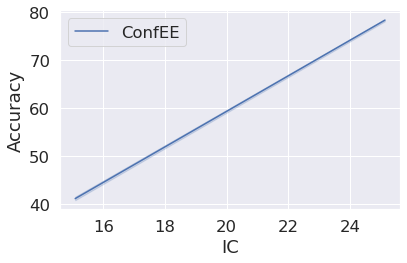

In [48]:
sns.set(font_scale=1.5) 


#sns.lineplot(data=filtered_boosted_df, x="average_IC", y="ACC", label="BoostedNet")
#sns.lineplot(data=filtered_weighted_df, x="average_IC", y="ACC", label="Weighted")
sns.lineplot(data=filtered_our_df, x="average_IC", y="test/gated_acc", label="ConfEE")
plt.xlabel('IC')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('perf_cost_'+dataset+'.pdf')

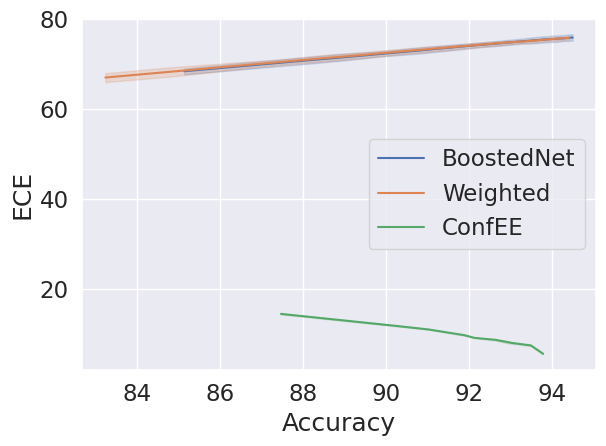

In [27]:
sns.set(font_scale=1.5)  # crazy big
sns.lineplot(data=filtered_weighted_df, x="average_ACC", y="ECE", label="BoostedNet")
sns.lineplot(data=filtered_boosted_df, x="average_ACC", y="ECE", label="Weighted")

sns.lineplot(data=filtered_our_df, x="average_ACC", y="test/gated_ece", label="ConfEE")
plt.xlabel('Accuracy')
plt.ylabel('ECE')
plt.tight_layout()
plt.savefig('perf_ece_'+dataset+'.pdf')

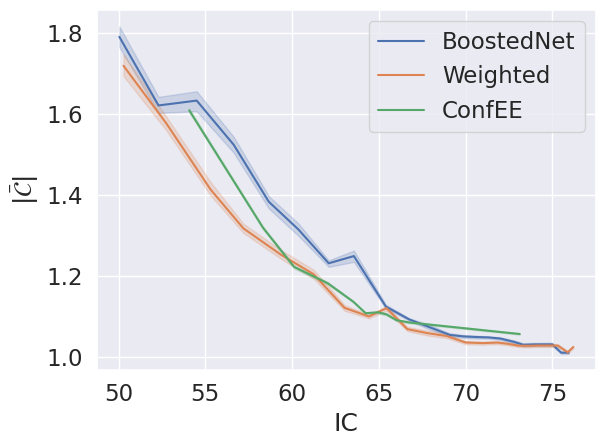

In [28]:
sns.set(font_scale=1.5)  # crazy big

sns.lineplot(data=filtered_boosted_df, x="average_IC", y="C", label="BoostedNet")
sns.lineplot(data=filtered_weighted_df, x="average_IC", y="C", label="Weighted")
sns.lineplot(data=filtered_our_df, x="average_IC", y="C", label="ConfEE")

plt.xlabel('IC')
plt.ylabel(r'$|\mathcal{\bar{C}}|$')
plt.tight_layout()
plt.savefig('inef_IC_'+dataset+'.pdf')


In [29]:
boosted_df_emp_vs_req = pd.DataFrame()
for cov_key in boosted_cov_keys:
    
    alpha = float(cov_key.split('cov_')[-1])
    df_cov = pd.DataFrame()
    df_cov['emp_alpha'] = 1-boosted_df[cov_key]/100.0
    df_cov['requested_alpha'] = alpha
    boosted_df_emp_vs_req = pd.concat([df_cov, boosted_df_emp_vs_req],axis=0, ignore_index=True)

weighted_df_emp_vs_req = pd.DataFrame()
for cov_key in boosted_cov_keys:
    
    alpha = float(cov_key.split('cov_')[-1])
    df_cov = pd.DataFrame()
    df_cov['emp_alpha'] = 1-weighted_df[cov_key]/100.0
    df_cov['requested_alpha'] = alpha
    weighted_df_emp_vs_req = pd.concat([df_cov, weighted_df_emp_vs_req],axis=0, ignore_index=True)
    
our_df_emp_vs_req = pd.DataFrame()

cov_keys_gated = []
cov_keys_gen = []
for c in cov_keys:
    if 'gen' in c:
        cov_keys_gen.append(c)
    else:
        cov_keys_gated.append(c)
for cov_key in cov_keys_gated:
    
    alpha = float(cov_key.split('cov_')[-1])
    df_cov = pd.DataFrame()
    df_cov['emp_alpha'] = 1-our_df[cov_key]
    df_cov['requested_alpha'] = alpha
    our_df_emp_vs_req = pd.concat([df_cov, our_df_emp_vs_req],axis=0, ignore_index=True)
    

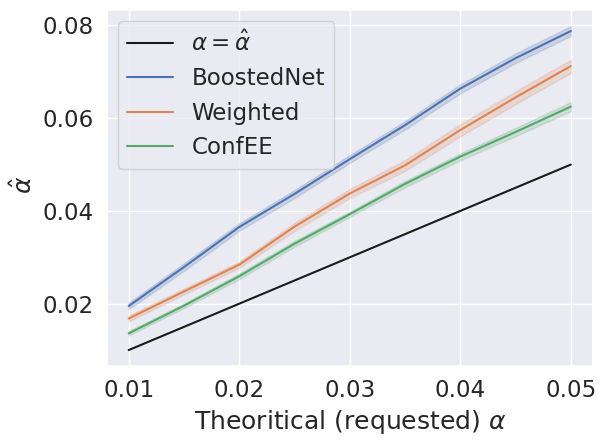

In [30]:
x = [0.01,0.05]
y = [0.01,0.05]
plt.plot(x,y, color='k',label=r'$\alpha = \hat{\alpha}$')
sns.lineplot(data=boosted_df_emp_vs_req, x="requested_alpha", y="emp_alpha", label="BoostedNet")
sns.lineplot(data=weighted_df_emp_vs_req, x="requested_alpha", y="emp_alpha", label="Weighted")
sns.lineplot(data=our_df_emp_vs_req, x="requested_alpha", y="emp_alpha", label="ConfEE")

plt.xlabel(r'Theoritical (requested) $\alpha$')
plt.ylabel(r' $\hat{\alpha}$')
plt.tight_layout()
plt.savefig('emp_vs_theoritical_'+dataset+'.pdf')


In [31]:
print(keys_all_acc)
print(keys_gated_accs)
L = 6

['test/acc0', 'test/acc1', 'test/acc2', 'test/acc3', 'test/acc4', 'test/acc5', 'test/acc_exit']
['test/gated_acc_1', 'test/gated_acc_2', 'test/gated_acc_3', 'test/gated_acc_4', 'test/gated_acc_5', 'test/gated_acc_0']


In [32]:
df_acc_ours = pd.DataFrame()
for metrics in list_dicts_ours:
    av_ic= np.mean(metrics['test/total_cost'])
    if av_ic> min_ic and av_ic < max_ic:
        for l in range(L):
            all_acc = 'test/acc'+str(l)
            gated_acc = 'test/gated_acc_'+str(l)

            if gated_acc in metrics:
                print(all_acc)
                df_acc = pd.DataFrame()
                df_acc['gated'] = metrics[gated_acc]
                df_acc['all'] = metrics[all_acc]
                df_acc['gate'] = l
                df_acc_ours = pd.concat([df_acc_ours, df_acc],axis=0, ignore_index=True)
            


test/acc3
test/acc4
test/acc5
test/acc3
test/acc4
test/acc5
test/acc2
test/acc3
test/acc4
test/acc5
test/acc2
test/acc3
test/acc4
test/acc5
test/acc4
test/acc5
test/acc3
test/acc4
test/acc5
test/acc1
test/acc2
test/acc3
test/acc4
test/acc5
test/acc2
test/acc3
test/acc4
test/acc5
test/acc3
test/acc4
test/acc5
test/acc3
test/acc4
test/acc5
test/acc0


ValueError: Length of values (10) does not match length of index (2)

In [33]:
df_acc_boosted = pd.DataFrame()
for metrics in list_dict_boosted:
    av_ic= np.mean(metrics['EXPECTED_FLOPS'])
    if av_ic> min_ic and av_ic < max_ic:
        for l in range(L):
            all_acc = 'ALL_ACC_PER_GATE_'+str(l)
            gated_acc = 'GATED_ACC_PER_GATE_'+str(l)

            if gated_acc in metrics:
                df_acc = pd.DataFrame()
                df_acc['gated'] = metrics[gated_acc]
                df_acc['all'] = metrics[all_acc]
                df_acc['gate'] = l
                df_acc_boosted = pd.concat([df_acc_boosted, df_acc],axis=0, ignore_index=True)
            


<Axes: xlabel='gate', ylabel='all'>

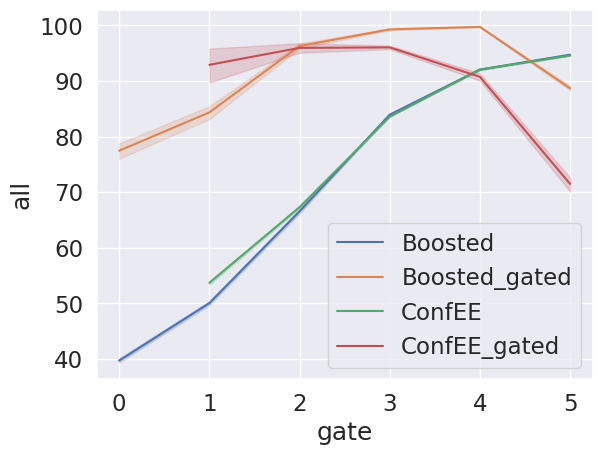

In [34]:
sns.lineplot(data=df_acc_boosted, x="gate", y="all", label="Boosted")
sns.lineplot(data=df_acc_boosted, x="gate", y="gated", label="Boosted_gated")
sns.lineplot(data=df_acc_ours, x="gate", y="all", label="ConfEE")
sns.lineplot(data=df_acc_ours, x="gate", y="gated", label="ConfEE_gated")